In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
# !pip install tensorflow-io
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, ShuffleSplit, StratifiedKFold  
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.manifold import Isomap, MDS
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.manifold import LocallyLinearEmbedding as lle
from sklearn.decomposition import PCA, FastICA, FactorAnalysis, KernelPCA
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier

import math
import random
import time
import sys
import os

Libraries have been imported

Import data:  start by setting up paths and file names for looping the import

In [2]:
# import files
# paths
path = "/kaggle/input/comp309-2022/"
trn_path = "training-data/"
tst_path = "test-data/"

# file names
gens = ['hip-hop', 'alternative', 'electronic', 'ska', 'childrens music',
       'folk', 'soul', 'blues', 'comedy', 'movie', ]
# object names
gen_names = ['hip', 'alt', 'elec', 'ska', 'kids',
       'folk', 'soul', 'blues', 'comedy', 'movie', ]


Iterate through each file, import the datasets as arrays

In [3]:
# test data
test = pd.read_csv(path+tst_path+"test.csv")
print(test.shape)
print(test.columns)

# object to hold training data
data = []

# bring data into memory
for i, gen in enumerate(gens):
    
    # access file
    obj = pd.read_csv(path+trn_path+gen+".csv")
    data.append(obj)

(30931, 18)
Index(['instance_id', 'artist_name', 'track_name', 'track_id', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence'],
      dtype='object')


Transfer all datasets into a single array

In [4]:
# get all the data into one object
all_data = []
# print(all_data)

# loop through each genre in data
for i, gen in enumerate(data):
    
    # loop through each row of the genre table and add to all_data
    for r in range(len(data[i])):
        d = data[i].iloc[r, :]
        all_data.append(d)
        
# convert dataset to pandas dataframe
all_data = pd.DataFrame(all_data)
all_data.reset_index(inplace = True, )

# ... and grab some of the key features
print("the shape of the dataset is:", all_data.shape)
print("the features of the dataset are:", all_data.columns.values)

the shape of the dataset is: (50000, 20)
the features of the dataset are: ['index' 'instance_id' 'artist_name' 'track_name' 'track_id' 'popularity'
 'acousticness' 'danceability' 'duration_ms' 'energy' 'instrumentalness'
 'key' 'liveness' 'loudness' 'mode' 'speechiness' 'tempo' 'time_signature'
 'valence' 'genre']


In [5]:
# create the training dataset for training the final model
train = all_data.copy(deep = True)

In [6]:
# # reduce the number of data points for dev and training
# sel_ind =np.random.randint(1, 49998, size = 5000)
# all_data = all_data.iloc[sel_ind, :]

In [7]:
# and capture some of the categoric features for reference later
genres = all_data.genre.unique()
keys = all_data.key.unique()
majors = all_data['mode'].unique()
time_sigs = all_data.time_signature.unique()
numerics = all_data.select_dtypes(include = [np.number]).columns.tolist()

Summarise key features of the dataset:
- dataset has 50000 rows
- dataset has 19 features
- the dataset has seven categorical features 'artist_name', 'track_name', 'track_id', 'key', 'mode', 'time_signature', and the class label 'genre'
- the dataset has 12 numerical features 'instance_id', 'popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', and 'valence'

Of the categorical features, 'key' and 'mode' refer to musical attributes (i.e. 'key' is the predominant note that the song is played, 'mode' indicates if the song is in the major or minor key) and could provide some indication of musical genre. 


In [8]:
all_data.describe()

index  instance_id    popularity  acousticness  danceability  \
count  50000.000000   50000.0000  50000.000000  50000.000000  50000.000000   
mean    2499.500000  126285.9000     37.680800      0.350953      0.572506   
std     1443.390078   79504.4176     18.205972      0.342806      0.159419   
min        0.000000   43000.0000      0.000000      0.000001      0.061700   
25%     1249.750000   62500.7500     25.000000      0.024900      0.467000   
50%     2499.500000  102540.5000     41.000000      0.219000      0.576000   
75%     3749.250000  170499.2500     51.000000      0.699000      0.685000   
max     4999.000000  313859.0000     96.000000      0.996000      0.989000   

        duration_ms        energy  instrumentalness      liveness  \
count  5.000000e+04  50000.000000      50000.000000  50000.000000   
mean   1.817114e+05      0.618753          0.093378      0.256996   
std    1.456144e+05      0.242324          0.231847      0.238818   
min   -1.000000e+00      0.000216          0.000000      0.012400   
25%    1.078498e+05      0.445000          0.000000      0.101000   
50%    1.953085e+05      0.641000          0.000033      0.144000   
75%    2.469362e+05      0.825000          0.010600      0.326000   
max    4.830606e+06      0.999000          0.993000      1.000000   

           loudness   speechiness       valence  
count  50000.000000  50000.000000  50000.000000  
mean      -8.736643      0.172855      0.485764  
std        4.396351      0.258632      0.247137  
min      -38.445000      0.022200      0.000000  
25%      -11.040000      0.037400      0.289000  
50%       -7.820000      0.057600      0.477000  
75%       -5.562000      0.153000      0.676000  
max        3.744000      0.965000      1.000000

Of the numerical features:
- 'instance_id' is an arbitrary value for identification only
- 'popularity' has integer values ranging from 0 - 96, with median 41
- 'acoustic' has float values ranging 0-1, with mean 0.35
- 'danceability' has float values, ranging 0-1, with mean 0.57
- 'duration_ms' has float values, ranging from -1 to 4.8e06, with mean 1.5e05
- 'energy' has float values, ranging from 0-1, with mean 0.62
- 'instrumentalness' has float values, ranging from 0-1, with mean 0.09
- 'liveness' has float values, ranging from 0-1, with mean 0.26
- 'loudness' has float values, ranging from -38.4 to 3.7
- 'speechness' has float values, ranging from 0-1, with mean 0.17
- 'valence' has float values, ranging from 0-1, with mean 0.49

We can view distributions by feature as histograms:

In [9]:
# function to plot histograms
def make_histograms(df, fname = 'histograms'):
    
    num_feats = [] # holding object for numeric features
    
    # loop to detect and capture the numeric features
    for i, feat in enumerate(df.columns.values):
        num = df[feat].dtypes # check dtype of each feature
        
        # keep numeric (int64 and float64)
        if (num == 'int64'):
            num_feats.append(feat)
        elif (num == 'float64'):
            num_feats.append(feat)
    
    
    ################# set up plot parameters for matplotlib ################
    
    # configure the best plot layout based on number of features
    n = len(num_feats)
    
    # kick an error if there are no numeric features
    if n < 1:
        print("no numeric features in dataset")
        
    # anything up to five in a single row
    elif n <= 5:
        figsize = (2 * n, 3)
        plot_dims = (1, n)
        
    # six features switch to 2 x 3
    elif n == 6:
        figsize = (n , 6)
        plot_dims = (2, n/2)
        
    # seven or eight features in 2 x 4
    elif n <= 8:
        figsize = (n, 6)
        plot_dims = (2, 4)
    
    # nine features in 3 x 3
    elif n == 9:
        figsize = (n, n)
        plot_dims = (3, 3)
        
    # ten features in 2 X 5
    elif n == 10:
        figsize = (n, 6)
        plot_dims = (2, 5)
        
    # 11 or 12 features in 3 x 4
    elif n <= 12:
        figsize = (8, 9)
        plot_dims = (3, 4)
    
    # up to 15 features in 3 x 5
    elif n <= 15:
        figsize = (10, 9)
        plot_dims = (3, 5)
    
    # 16 features in a 4 x 4
    elif n == 16:
        figsize = (8, 12)
        plot_dims = (4, 4)
    
    # everything over 16 features in five column layout
    else:
        y_ = (int(n/5))
        figsize = (10, y_ * 3)
        plot_dims = (y_+1, 5)
        
    # extract the row value from plot_dims for ease of use   
    rows = plot_dims[0]
    cols = plot_dims[1]
    
    
    
    ################### set up the plot ########################    
    # set up the main plot
    # use figsize, estimated based on number of numeric features
    fig = plt.figure(figsize = figsize)
    subfigs = fig.subfigures(1,1)
    
    # use row and column size, defined based on number of numeric features
    sub = subfigs.subplots(rows, cols)
    
    # iterate through features and assign each feature to the plot
    for i, feat in enumerate(df.loc[:, num_feats].columns.values):
        
        # assign the feature to a location in the row x col plot
        # the row location increases whenever i reaches a multiple of col
        r = int(i/cols)
        
        # the col location increases each step, then resets when row increases by 1
        c = i - (r * cols)
        
        # pass location to matplotlib figure
        ax = sub[r][c]
        # create the histogram of the feature
        ax.hist(all_data.loc[:, feat])

        # tidy the plot so it's not too cluttered, we don't really need values
        # we are focussed on the visualisation
        ax.set_xticklabels("")
        ax.set_yticklabels("")
        ax.set_title("{}".format(feat))

    # display on screen    
    plt.show()
    # save to file 
    plt.savefig("{}_histograms.png".format(fname))   

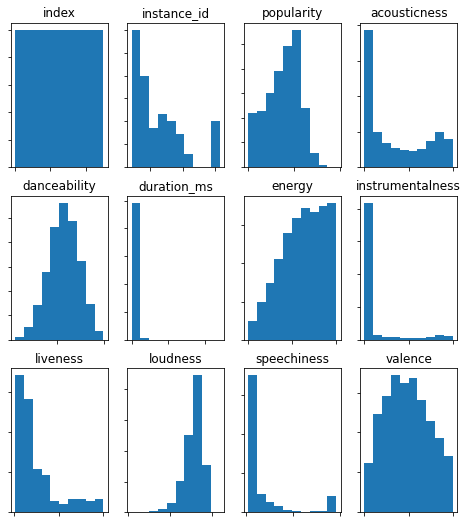

<Figure size 432x288 with 0 Axes>

In [10]:
num_cols = all_data.iloc[:, all_data.columns.isin(numerics)]
raw_all_data = make_histograms(num_cols, "raw")

We can see from the histograms that 'acousticness', 'duration_ms', 'instrumentalness', and 'speechiness' are heavily weighted toward low values, with more than three-quarters of the instances in the lowest bins.  Most of these features provide little discriminatory power because they are essentially the same across all of the different classes, so will be removed from the model. 

We can view the first few lines of the dataset:

In [11]:
all_data.head

<bound method NDFrame.head of        index  instance_id       artist_name                 track_name  \
0          0        70991       empty_field  Zombie (feat. Rich Brian)   
1          1        70992             Logic              City Of Stars   
2          2        70993           TobyMac             Me Without You   
3          3        70994         EARTHGANG                      Build   
4          4        70995              Tyga    Holdin On (feat. 24hrs)   
...      ...          ...               ...                        ...   
49995   4995       124995  Scatman Crothers                 Sweet Lips   
49996   4996       124996   Bruno Pelletier           Amsterdam - Live   
49997   4997       124997    Henri Salvador         Tu es venue - live   
49998   4998       124998   Bruno Pelletier                  Peut-être   
49999   4999       124999    Henri Salvador          C Est Noel M Amie   

                     track_id  popularity  acousticness  danceability  \
0      2

We see that 'tempo' has a question mark as a value and there are some songs with a 'duration_ms' of -1, which is an invalid value.  We can replace these values with any value.  So we should check how many times these values appear to determine how we can treat them.

In [12]:
quest = len(all_data[all_data.loc[:, "tempo"] == "?"])
negs = len(all_data[all_data.loc[:, "duration_ms"] < 0])
print("tempo has {} '?' values, duration_ms has {} negative values".format(quest, negs))

tempo has 7461 '?' values, duration_ms has 10022 negative values


Negative values appear 10,000 times in 'duration_ms'. '?' shows up in 7461 rows of the 'tempo' feature.

Finally we check for missing values in all features. 

In [13]:
# function to check for missing values
def any_missing(df):
    misses = []
    
    for f, feat in enumerate(df.columns.values):
        missing = df.loc[:, feat].isna().sum()
        
        # append feature if it has missing features
        if missing >0:
            misses.append(feat)
            print("{} has {} missing values".format(feat, missing))
            
    if len(misses) == 0:
        print("The dataset has no missing values")
            
    return misses

In [14]:
all_data_missing = any_missing(all_data)

The dataset has no missing values


There are no null or missing values in any of the features.  So we can begin cleaning the data by:
- replacing the invalid values (-1 in 'duration_ms' and '?' in 'tempo') with the average of valid values in each feature
- encoding categoric features with limited values ('key', 'mode', 'time_signature', and class label 'genre')


In [15]:
# calculate mean of valid values
tempo_mean = all_data.loc[all_data['tempo'] != '?', 'tempo'].astype(float).mean()
# dur_mean = all_data.loc[all_data['duration_ms'] > 0, 'duration_ms'].mean()
# print("tempo_mean = {}, dur_mean = {}".format(tempo_mean, dur_mean))


In [16]:
# make a copy of the original dataset in case it goes pear shaped
all_data_copy = all_data.copy(deep = True)

# and create a version where we remove the instances with invalid features
removed_data = all_data.copy(deep = True)
removed_data.drop(removed_data[removed_data.tempo == '?'].index, inplace = True)
removed_data.drop(removed_data[removed_data.duration_ms < 0].index, inplace = True)

In [17]:
# replace -1 with mean of valid duration
# all_data.loc[:, "duration_ms"].mask(all_data.loc[:, "duration_ms"] <= 0, dur_mean, inplace = True)

# replace ? with 0
# all_data.loc[:,"tempo"].mask(all_data.loc[:, "tempo"] == "?", 0, inplace = True)
all_data.replace(to_replace = "?", value = 0, inplace = True)
all_data['tempo'] = pd.to_numeric(all_data['tempo'])
# pd.DataFrame(encoder.fit_transform(df[['team']]).toarray())

converts = ['key', 'mode', 'time_signature',]

# replace key with encoded value
for i, c in enumerate(converts):
    # add encoders to all_data
    enc = OneHotEncoder(handle_unknown = 'ignore')
    transformed = enc.fit_transform(all_data[[c]])
    all_data.drop(columns = [c], axis = 1, inplace = True)
    all_data[enc.categories_[0]] = transformed.toarray()
    
#     # add encoders to removed_data
#     rem_enc = OneHotEncoder(handle_unknown = 'ignore')
#     rem_transformed = rem_enc.fit_transform(removed_data[[c]])
#     removed_data.drop(columns = [c], axis = 1, inplace = True)
#     removed_data[rem_enc.categories_[0]] = rem_transformed.toarray()

    
# replace genre label with encoded value
enc_genre = LabelEncoder()
all_data.genre = enc_genre.fit_transform(all_data.genre)
rem_genre = LabelEncoder()
removed_data.genre = enc_genre.fit_transform(removed_data.genre)

In [18]:
# all_data = all_data_copy.copy()
# all_data.head()
print("the shape of the data set with refitted data is: ", all_data.shape)
print("the shape of the removed_data set is: ", removed_data.shape)

the shape of the data set with refitted data is:  (50000, 35)
the shape of the removed_data set is:  (34020, 20)


In [19]:
quest1 = len(all_data[all_data.loc[:, "tempo"] == '?'])
print("tempo has {} '?' values".format(quest1))
# negs1 = len(all_data[all_data.loc[:, "duration_ms"] < 0])
# print("duration_ms has {} negative values".format(negs1))

tempo has 0 '?' values


We can check how the histograms look now...

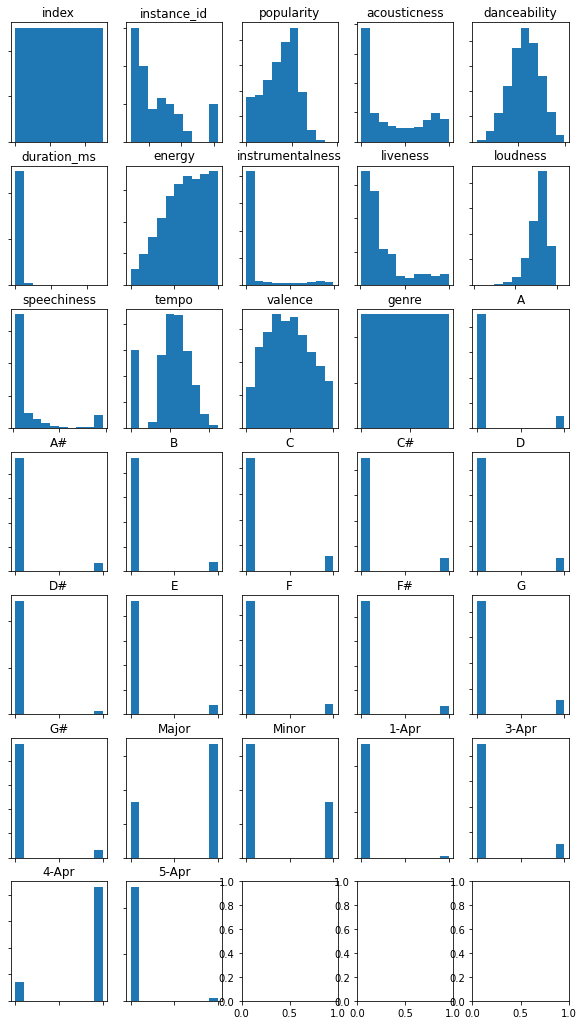

<Figure size 432x288 with 0 Axes>

In [20]:
make_histograms(all_data, "tempo_replacednulls")

Newly adjusted feature 'tempo' appears normally distributed after replacing invalid values with the mean of the valid values.  The effect on 'duration_ms' is much lower, predictable considering the lower number of replaced values and the already high tendency toward the lower end of the distribution.  'key' is a newly encoded feature and has an interesting distribution that peaks at the margins. 'duration_ms', 'instrumentalness', and 'speechiness' are still heavily loaded toward the lower end of the distribution.   

Some features might not be very useful because they are dominated by a few values:
- [instrumentalness] 75th percentile is lower than mean so will be removed from model
- [duration_ms] adjusted mean is 230 seconds, 75th percentile is 250 seconds, but max is 480 seconds, so we will apply a ceiling to reduce the effect of those long songs.  90th percentile is around 300000 ms, 99th percentile around 500000ms.  This feature will be clipped so all instances above 300000ms will be set to 300000ms.

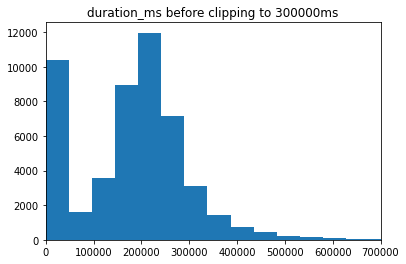

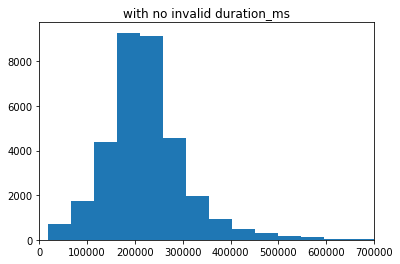

In [21]:
# plt before clipping
plt.hist(all_data.loc[:, "duration_ms"], bins =100)
plt.title("duration_ms before clipping to 300000ms")
plt.xlim(0, 700000)
plt.show()

# plt before clipping
plt.hist(removed_data.loc[:, "duration_ms"], bins =100)
plt.title("with no invalid duration_ms")
plt.xlim(0, 700000)
plt.show()

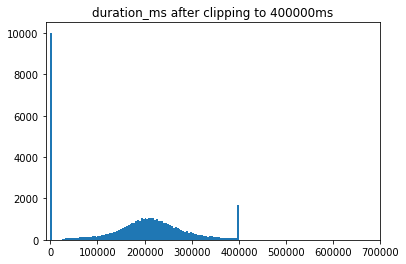

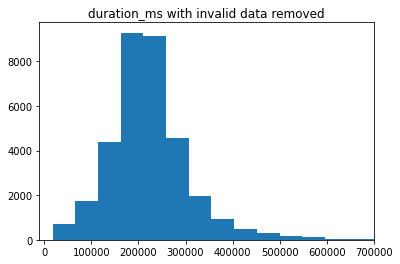

In [22]:
# new object with clipped data
clipped_data = all_data.loc[:, 'duration_ms'].clip(0, 400000)

plt.hist(clipped_data, bins =100)
plt.title("duration_ms after clipping to 400000ms")
plt.xlim(-10000, 700000)
plt.show()

plt.hist(removed_data.duration_ms, bins = 100)
plt.title("duration_ms with invalid data removed")
plt.xlim(-10000, 700000)
plt.show()


We see that clipping to 300000ms has very little effect on the distribution.  In fact, the plot shows that the vast majority of instances are less than 1.0e06, so we will reduce the max clipping to 100000ms

In [23]:
# function to create a scatter plot from two columns (x, y) of a dataframe (df)
def make_scatters(df, x, y, color):

    color_name = color.name
    
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.scatter(df.loc[:, x], df.loc[:, y], c = color, alpha = 0.2)
    
    ax.set_title("{} and {} scatterplot by {}".format(x, y, color_name))
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    
    plt.show()
    plt.savefig("{}_{}_scatter.png".format(x, y))
    
    return ax

In [24]:
# all_data[numerics[3]]
best_numerics = ['tempo', 'popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'valence', 'instrumentalness',
                'liveness', 'loudness', 'speechiness']
next_best_numerics = best_numerics.copy()

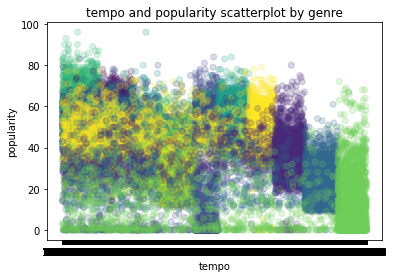

<Figure size 432x288 with 0 Axes>

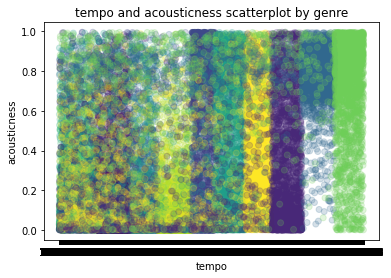

<Figure size 432x288 with 0 Axes>

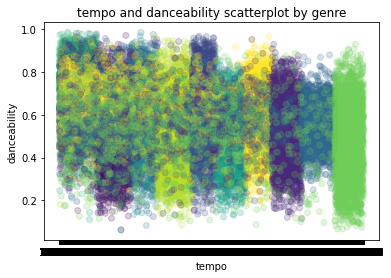

<Figure size 432x288 with 0 Axes>

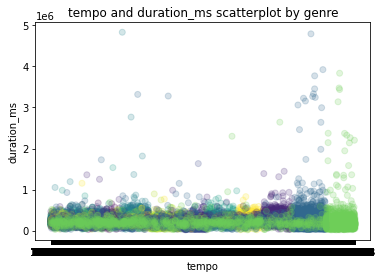

<Figure size 432x288 with 0 Axes>

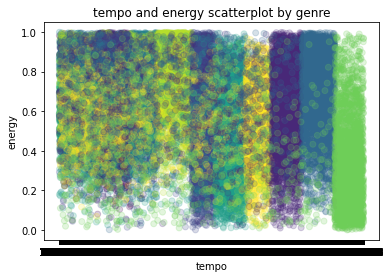

<Figure size 432x288 with 0 Axes>

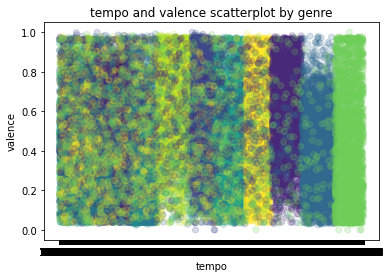

<Figure size 432x288 with 0 Axes>

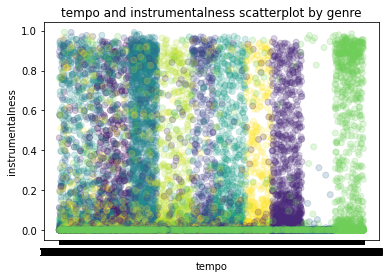

<Figure size 432x288 with 0 Axes>

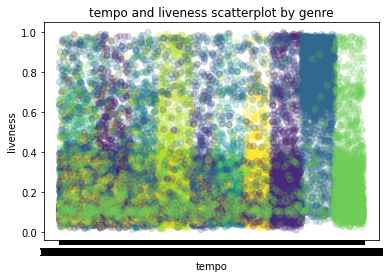

<Figure size 432x288 with 0 Axes>

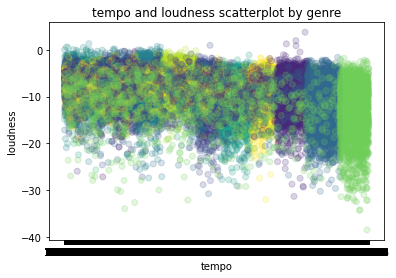

<Figure size 432x288 with 0 Axes>

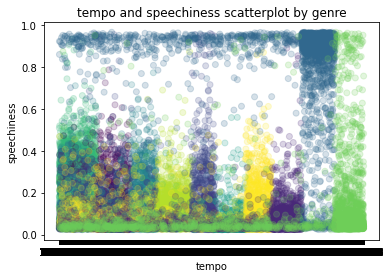

<Figure size 432x288 with 0 Axes>

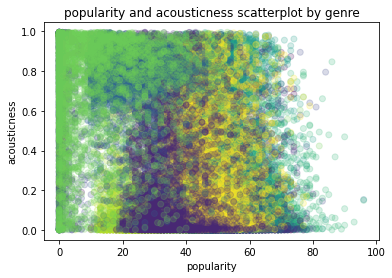

<Figure size 432x288 with 0 Axes>

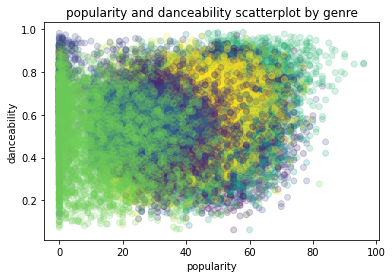

<Figure size 432x288 with 0 Axes>

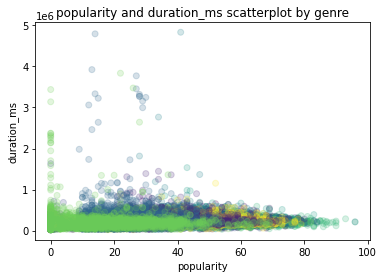

<Figure size 432x288 with 0 Axes>

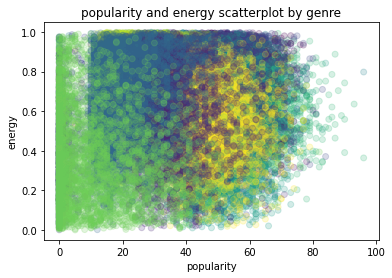

<Figure size 432x288 with 0 Axes>

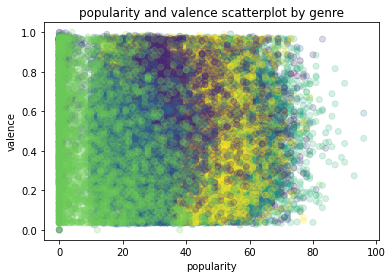

<Figure size 432x288 with 0 Axes>

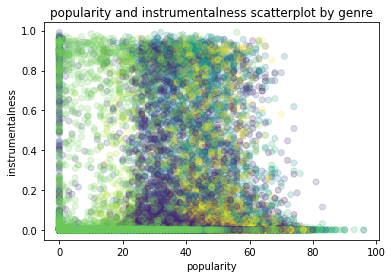

<Figure size 432x288 with 0 Axes>

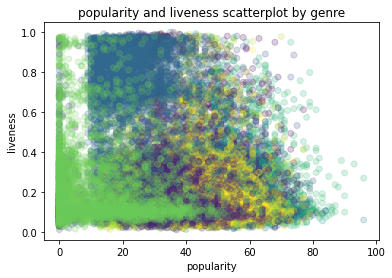

<Figure size 432x288 with 0 Axes>

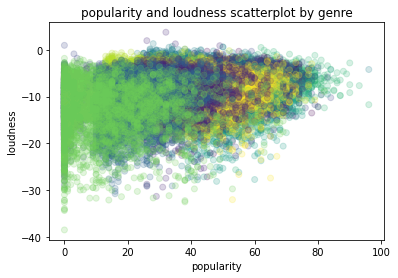

<Figure size 432x288 with 0 Axes>

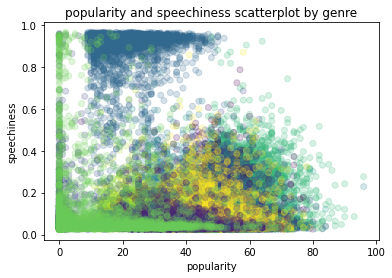

<Figure size 432x288 with 0 Axes>

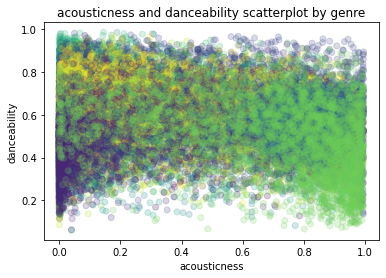

<Figure size 432x288 with 0 Axes>

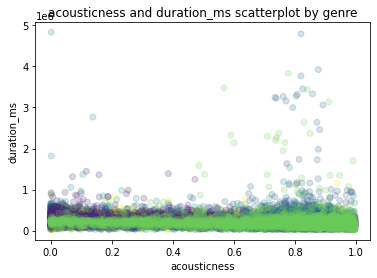

<Figure size 432x288 with 0 Axes>

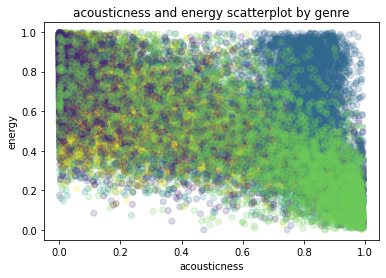

<Figure size 432x288 with 0 Axes>

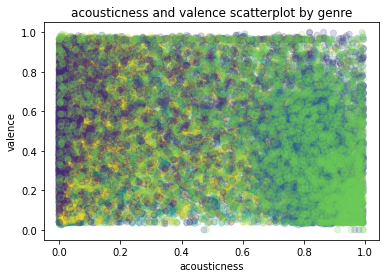

<Figure size 432x288 with 0 Axes>

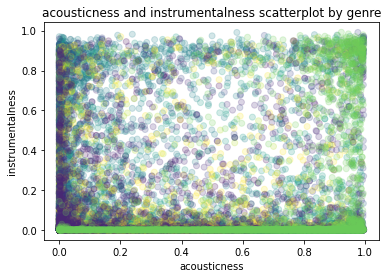

<Figure size 432x288 with 0 Axes>

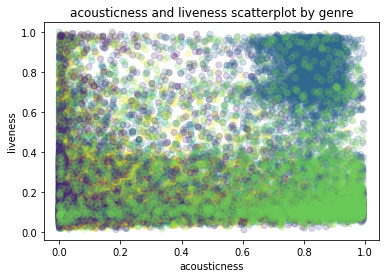

<Figure size 432x288 with 0 Axes>

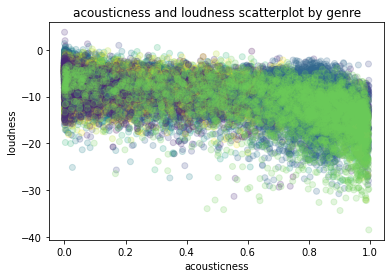

<Figure size 432x288 with 0 Axes>

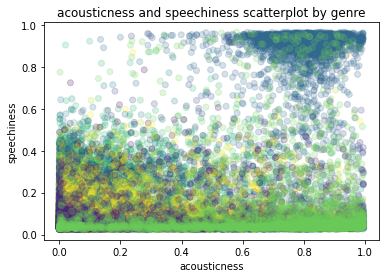

<Figure size 432x288 with 0 Axes>

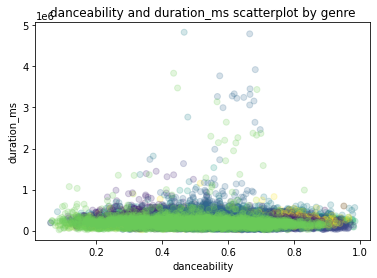

<Figure size 432x288 with 0 Axes>

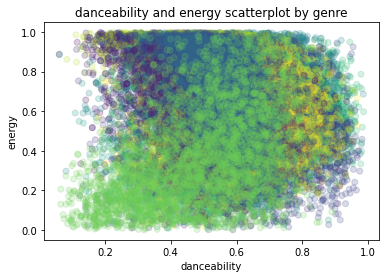

<Figure size 432x288 with 0 Axes>

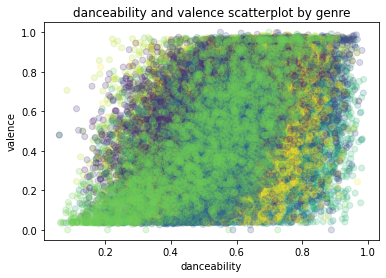

<Figure size 432x288 with 0 Axes>

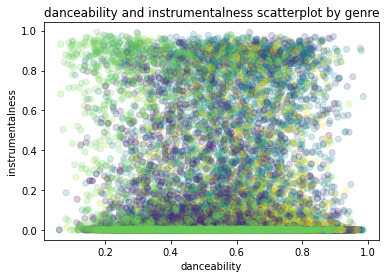

<Figure size 432x288 with 0 Axes>

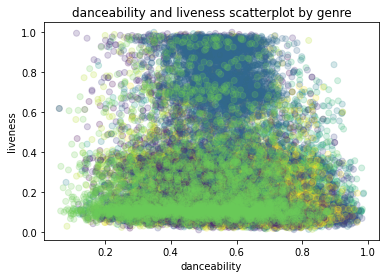

<Figure size 432x288 with 0 Axes>

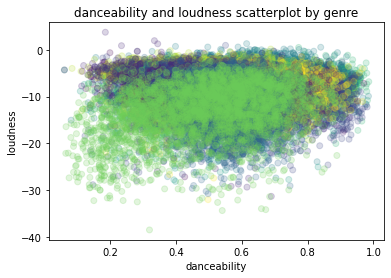

<Figure size 432x288 with 0 Axes>

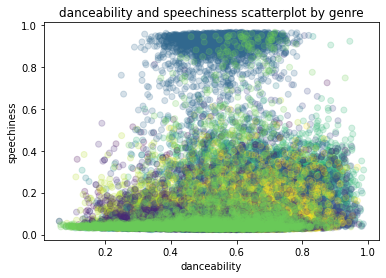

<Figure size 432x288 with 0 Axes>

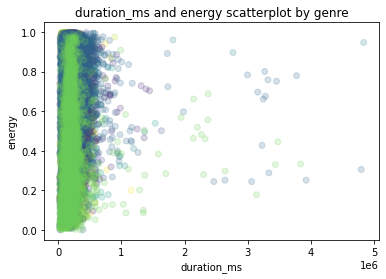

<Figure size 432x288 with 0 Axes>

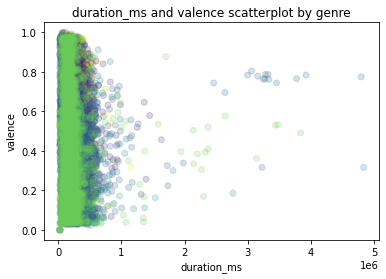

<Figure size 432x288 with 0 Axes>

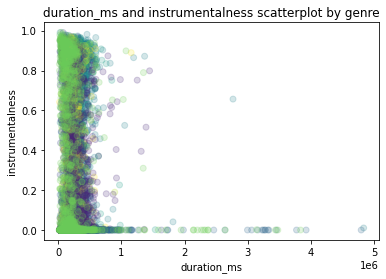

<Figure size 432x288 with 0 Axes>

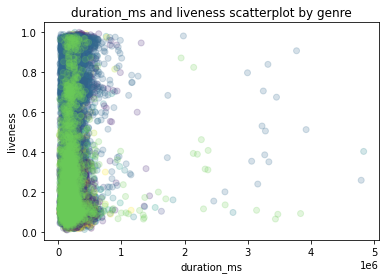

<Figure size 432x288 with 0 Axes>

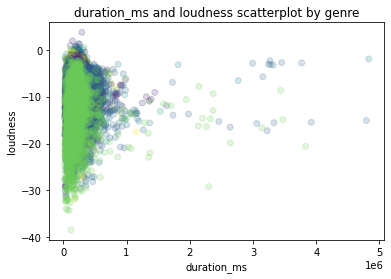

<Figure size 432x288 with 0 Axes>

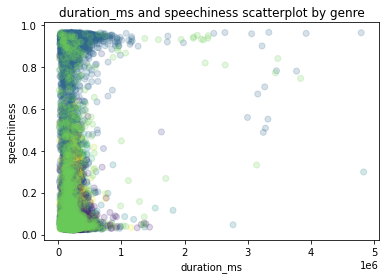

<Figure size 432x288 with 0 Axes>

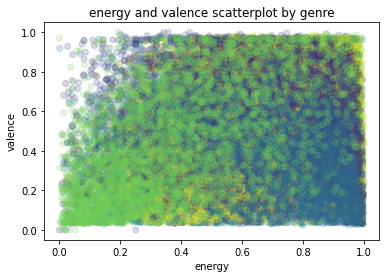

<Figure size 432x288 with 0 Axes>

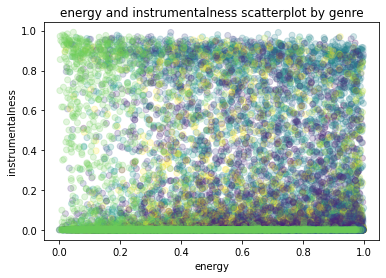

<Figure size 432x288 with 0 Axes>

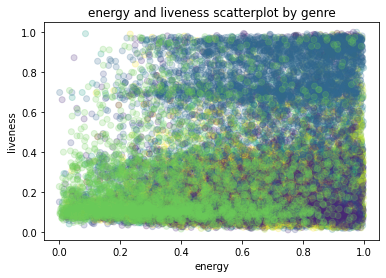

<Figure size 432x288 with 0 Axes>

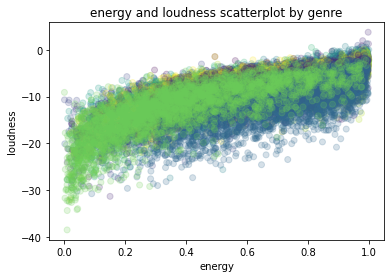

<Figure size 432x288 with 0 Axes>

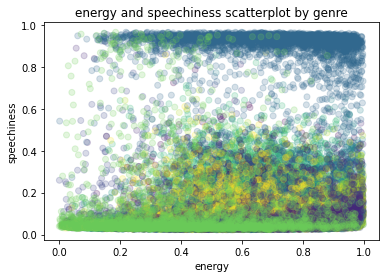

<Figure size 432x288 with 0 Axes>

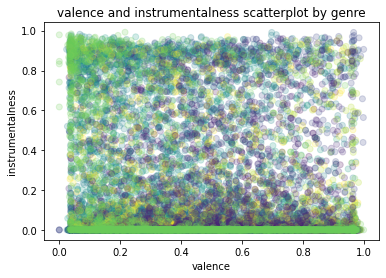

<Figure size 432x288 with 0 Axes>

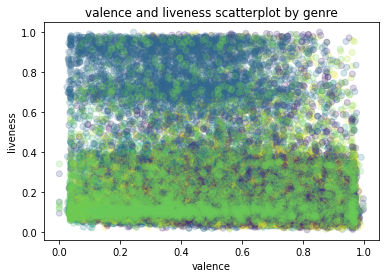

<Figure size 432x288 with 0 Axes>

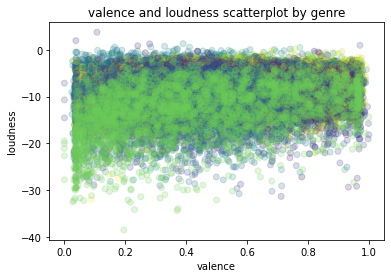

<Figure size 432x288 with 0 Axes>

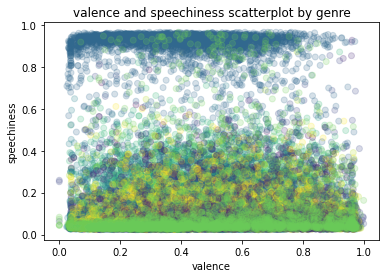

<Figure size 432x288 with 0 Axes>

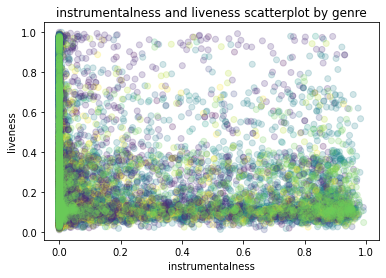

<Figure size 432x288 with 0 Axes>

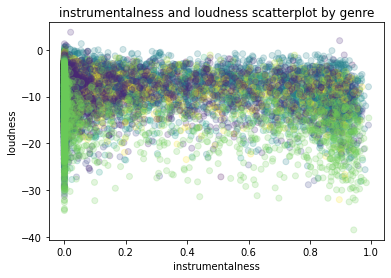

<Figure size 432x288 with 0 Axes>

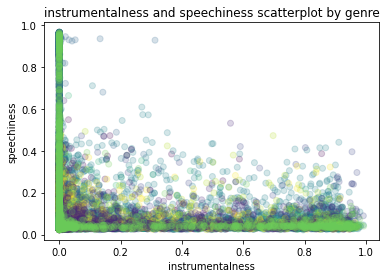

<Figure size 432x288 with 0 Axes>

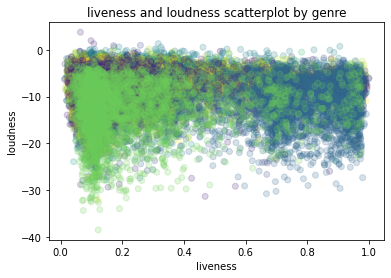

<Figure size 432x288 with 0 Axes>

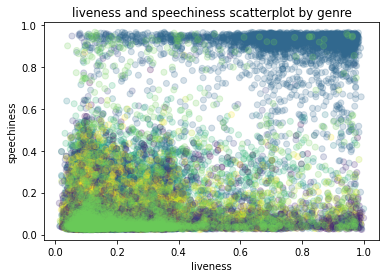

<Figure size 432x288 with 0 Axes>

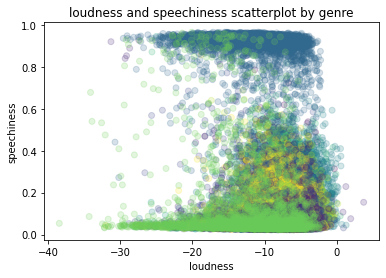

<Figure size 432x288 with 0 Axes>

In [25]:
# go through all the numeric columns
while len(next_best_numerics) != 0 :
    # capture remaining features
    feat = next_best_numerics[0]
    cols = next_best_numerics[1:]
    
    # iterate through remaining features
    for c in cols:
        # plot the pairs plot
        ax = make_scatters(removed_data, x = feat, y = c, color = removed_data.genre)
        
    # pop the current feature    
    next_best_numerics.pop(0)

We can see that some feature pairs provide distinct clusters of activity, indicated by strong bands or blobs of the same colour.  'popularity' shows banding with most pairs, indicating that certain genres tend to score similarly in terms of popularity. 'speechiness' appears to have a strong set of similar colours at its higher end peak.

'tempo' consistently has clear banding of the same colour (i.e. 'genre'), indicating it has a high level of correlation to the genre class label.  When paired with different features, certain genres are more clearly visible in the scatterplot, so we will enure those features are all retained in the main model.

In [26]:
# function to take three features and generate 3d scatter plots
# function to create a scatter plot from two columns (x, y) of a dataframe (df)
def make_3d(df, x, y, z, color):
    
    color_name = color.name
        
    fig = plt.figure()
    
    ax = fig.add_subplot(projection = '3d')
    ax.scatter(df.loc[:, x], 
               df.loc[:, y], 
               df.loc[:, z], 
               c = color,)
    
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)
    ax.set_title("{}, {} and {} scatterplot by {}".format(x, y, z, color_name))

    plt.show()
    plt.savefig("{}_{}_{}_3D_scatter.png".format(x, y, z))
    
    return ax

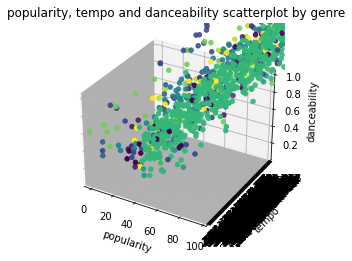

<Figure size 432x288 with 0 Axes>

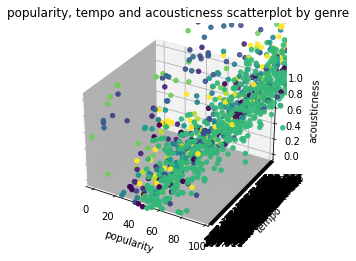

<Figure size 432x288 with 0 Axes>

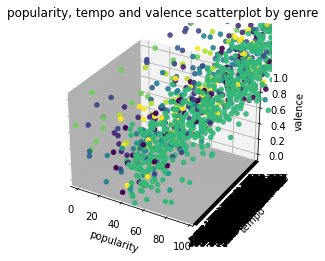

<Figure size 432x288 with 0 Axes>

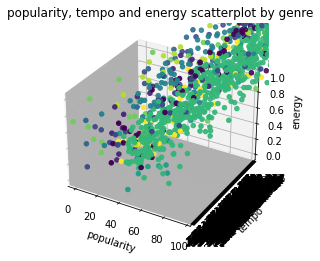

4


<Figure size 432x288 with 0 Axes>

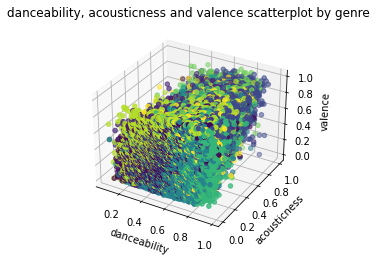

<Figure size 432x288 with 0 Axes>

2
0


In [27]:
# collect the features that seem to have good clustering of colours, indicate that genres are grouped 
# in relation to this feature
good_ones = ['popularity', 'tempo',  'danceability', 'acousticness', 'valence', 'energy' ]
i = 0
the_plot = []

while len(good_ones) != 0:
    
    x_ = good_ones[0]
    y_ = good_ones[1]
    cols = good_ones[2:]
    
    for c in cols:
        
        if i < 5:
             
            make_3d(removed_data, x_, y_, c, removed_data.genre)
            
            i += 1
    
        else:
            
            i = 0
            plt.show()
    
    # remove the first two features (x, y) from the base list
    good_ones.pop(0) # removes x
    good_ones.pop(0) # removes y which is now at element 0
    print(len(good_ones))

In [28]:
# don't scale the categoric or label features
excl = ['instance_id','artist_name', 'track_name', 'track_id', 'genre']

# scale numeric features for comparability
scaler = StandardScaler()

# scale away
all_data.loc[:, ~all_data.columns.isin(excl)] = scaler.fit_transform(all_data.loc[:, ~all_data.columns.isin(excl)].to_numpy())


In [29]:
# forgot to put the good ones object back...
good_ones = ['popularity', 'tempo',  'danceability', 'acousticness', 'valence', 'energy' ]

# and scale the removed data but just the features we keep
scaler_rem = StandardScaler()
removed_data.loc[:, good_ones] = scaler_rem.fit_transform(removed_data.loc[:, good_ones])

Using pair plots, there are some feature correlations:
- positive correlation between energy and loudness
- negative correlation between acoustic and loudness

[tempo], [danceability] look close to normally distributed.
[duration_ms], [speechiness], [instrumentalness], and [liveness] look to have exponential distributions, with a high proportion of values at the lower end of those features.  These may be candidates for applying a ceiling to reduce the distortive effects of a few outlier, higher values (and improve the resolution of the scatter plots).

The remaining features are skewed, [acousticness],[popularity] with heavier right tails and [loudness] and [energy] with heavier left tails.  

Let's do some quick principal component analysis.

In [30]:
# split the dataset to train and test... but not the categorics
x_trn_pca, x_tst_pca, y_trn_pca, y_tst_pca = train_test_split(all_data.iloc[:, ~all_data.columns.isin(excl)],
                                                             all_data.genre,
                                                             random_state = 421)

In [31]:
# create  a function to generate a 3d plot from pca
def do_pca(x_train, x_test, y_train, y_test, n_components = 3):
    
    # call the function from sklearn
    pca = PCA(n_components = n_components)
    # fit and transform to all data
    pca_fit = pca.fit(x_train)
    x_pca_data = pca_fit.transform(x_test)

    # plot
    fig = plt.figure()
    ax = fig.add_subplot(projection = '3d')
    for g in genres:

        x = x_pca_data[:, 0]
        y = x_pca_data[:, 1]
        z = x_pca_data[:, 2]
        ax.scatter(x, y, 
                    c = y_test,
                  alpha = 0.3)

    ax.set_title("3D Projection of data using PCA")

    plt.show()
    
    print("Variance explained by each principal component \n", pca_fit.explained_variance_ratio_)
    print("Features in the model \n", pca_fit.feature_names_in_)
    return pca_fit

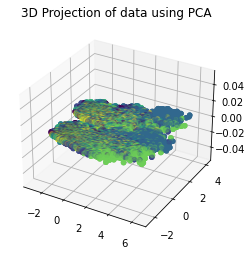

Variance explained by each principal component 
 [0.11251983 0.07312733 0.06488432 0.04779501 0.04060301 0.03822806]
Features in the model 
 ['index' 'popularity' 'acousticness' 'danceability' 'duration_ms' 'energy'
 'instrumentalness' 'liveness' 'loudness' 'speechiness' 'tempo' 'valence'
 'A' 'A#' 'B' 'C' 'C#' 'D' 'D#' 'E' 'F' 'F#' 'G' 'G#' 'Major' 'Minor'
 '1-Apr' '3-Apr' '4-Apr' '5-Apr']


PCA(n_components=6)

In [32]:
do_pca(x_trn_pca, x_tst_pca, y_trn_pca, y_tst_pca, n_components = 6)

With all numerical features, only 40% of the variance is explained by 6 principal components.  

We can try pca with fewer features, focussing on the good ones.

In [33]:
# split the dataset to train and test... but not the categorics
x_trn_pca_red, x_tst_pca_red, y_trn_pca_red, y_tst_pca_red = train_test_split(all_data.loc[:, good_ones],
                                                             all_data.genre,
                                                             random_state = 421)

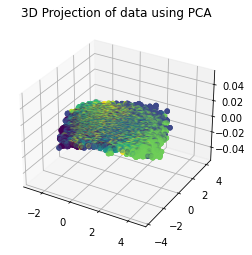

Variance explained by each principal component 
 [0.31481317 0.21713647 0.1750082 ]
Features in the model 
 ['popularity' 'tempo' 'danceability' 'acousticness' 'valence' 'energy']


PCA(n_components=3)

In [34]:
# pca with fewer features
reduced = do_pca(x_trn_pca_red, x_tst_pca_red, y_trn_pca_red, y_tst_pca_red, n_components = 3)
reduced

42472 unique [track_name], meaning 7,500 song names are repeated, possibly in multiple genres which will make classification difficult. Multiple artists may release their own version of the same song 
46378 unique [track_id], meaning 3,600 songs have a duplicated track id, possibly in mulitple genres, which will make classification difficult.  I'm not sure how this feature is generated, presumably an arbitrary reference from a database, but assume it should be unique to a single song, so should be useful in differentiating tracks with the same track name.
5679 unique [artist_name], meaning one artist may have multiple songs.  One artist may release multiple songs and possibly even variations of the same song.  This feature will determine if a track with the same name has been released by different artists, but unlikely to differentiate between versions from the same artist.

We can concatenate these three features to generate a new feature that we can use to check if there are any duplications of all three features (indicating an individual track has been duplicated.  No tracks are repeated in the dataset.

In [35]:
# shuffle the data so it doesn't train in blocks
all_data = all_data.sample(frac = 1)
rows = len(all_data)
trn_tst_split = 0.5
trn_val_split = int(0.5 * trn_tst_split * rows )


# don't use all the features: ['instance_id', 'artist_name', 'track_name', 'track_id', 'popularity',
#        'acousticness', 'danceability', 'duration_ms', 'energy',
#        'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
#        'speechiness', 'tempo', 'time_signature', 'valence', 'genre',
#        'combined'],
# that means remove:  categorical ['instance_id', 'artist_name', 'track_name', 'track_id']
# also remove: numeric ['key', 'mode', 'time_signature']

# split into train and validation
x_tr, x_tst, y_tr, y_tst = train_test_split(all_data.loc[:, ~all_data.columns.isin(excl)],
                                         all_data.genre, 
                                         random_state = 309,
                                         test_size = trn_tst_split,)

x_val = x_tr.iloc[:trn_val_split, :]
x_tr = x_tr.iloc[trn_val_split:, :]
y_val = y_tr.iloc[:trn_val_split]
y_tr = y_tr.iloc[trn_val_split:]
x_val = tf.convert_to_tensor(x_val)
y_val = tf.convert_to_tensor(y_val)
# print(x_tr.head(), y_tr.head())

2022-10-06 01:51:33.997628: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Baseline model: check for features with best predictive performance
Logistic Regression using L2 regularisation, to identify if there are redundant features.



In [36]:
# call the Logistic Regression model for the full set of numeric features
# initial run, default max iters reached, no convergence
# initial run, score 0.53, adjust l1_ratio from 0.3, 0.7, 0.2
## increased max_iters from 100, 200, 300
LR_elast = LogisticRegression(penalty = 'elasticnet',
                            random_state = 421,
                            solver = 'saga',
                            l1_ratio = 0.7,
                             max_iter = 300)

In [37]:
# check a few

C_ = [10, 1, 0.1, 0.01, 0.001]
# rat = [0.2, 0.5, 0.7]
# iters = [100, 200, 300]

for c in C_:
    LR_elast = LogisticRegression(penalty = 'elasticnet',
                            random_state = 421,
                            solver = 'saga',
                            l1_ratio = 0.7,
                                  C = c,
                             max_iter = 300)
    # fit the model to the data
    LR_full = LR_elast.fit(x_tr, y_tr)
    print("C: {}".format(c))
    print("Training accuracy:", LR_full.score(x_tr, y_tr))
    print("Test accuracy: ", LR_full.score(x_tst, y_tst))
    print("")

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


C: 10
Training accuracy: 0.552
Test accuracy:  0.5376



/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


C: 1
Training accuracy: 0.55192
Test accuracy:  0.53752



/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


C: 0.1
Training accuracy: 0.55056
Test accuracy:  0.53764

C: 0.01
Training accuracy: 0.53728
Test accuracy:  0.53392

C: 0.001
Training accuracy: 0.39184
Test accuracy:  0.39404



keep C = 0.1 (training accuracy 56%, test accuracy 54% ... about the same as C10, C1, better than C: 0.01 and C:0.001

In [38]:
def quick_classifications(classifier, x_train, x_test, y_train, y_test):
    
    # fit the classifier to the training data
    mod = classifier.fit(x_train, y_train)
    
    # predict the labels train data and store
    train_preds = mod.predict(x_train)
    
    # predict labels of test data and store
    test_preds = mod.predict(x_test)
    
    print('Training accuracy: ', accuracy_score(y_train, train_preds))
    print('Testing accuracy: ', accuracy_score(y_test, test_preds))
    
    print('{} Testing Report: \n {}'.format(str(classifier), classification_report(y_test, test_preds)))
    
    cm_nb = confusion_matrix(y_test, test_preds)
    plt.figure(figsize = (6, 6));
    plt.title(classifier);
    
    out = sns.heatmap(cm_nb, annot = True, 
                fmt = ".3f", 
                linewidths = .5, 
                square = True, 
               cmap = "YlGnBu")
               
    return mod, out, plt.xlabel('Predicted Label'), plt.ylabel('Actual Label');

Training accuracy:  0.55128
Testing accuracy:  0.5372
LogisticRegression() Testing Report: 
               precision    recall  f1-score   support

           0       0.34      0.37      0.36      2471
           1       0.46      0.34      0.39      2492
           2       0.11      0.06      0.07      2551
           3       0.94      0.93      0.93      2479
           4       0.60      0.65      0.62      2520
           5       0.46      0.54      0.50      2498
           6       0.65      0.78      0.71      2479
           7       0.67      0.73      0.70      2470
           8       0.53      0.66      0.59      2535
           9       0.36      0.32      0.34      2505

    accuracy                           0.54     25000
   macro avg       0.51      0.54      0.52     25000
weighted avg       0.51      0.54      0.52     25000

Training accuracy:  0.7052
Testing accuracy:  0.6106
GradientBoostingClassifier() Testing Report: 
               precision    recall  f1-score   su

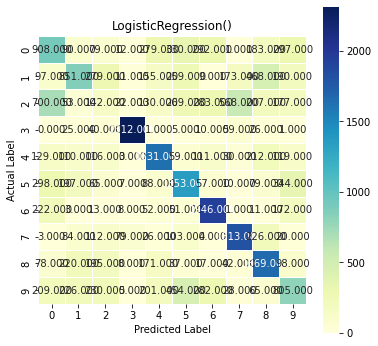

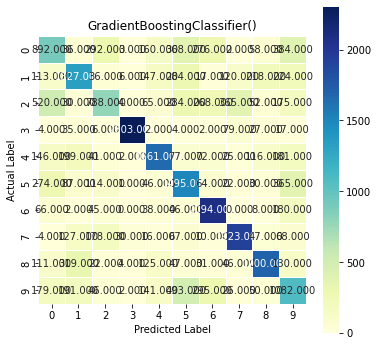

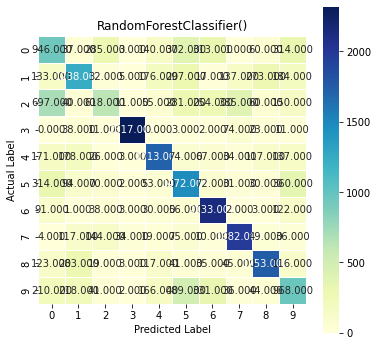

In [39]:
# vector to hold the classifiers
classy = [LogisticRegression(), GradientBoostingClassifier(), RandomForestClassifier(),]

super_classy = []
for c in classy:
    # run through the functions
    mod = quick_classifications(classifier = c, x_train = x_tr, x_test = x_tst, y_train = y_tr, y_test = y_tst)
    super_classy.append(mod)

In [40]:
# use a reduced dataset... there was some good differentiation with 'popularity', 
xtr_red, xts_red, ytr_red, yts_red = train_test_split(all_data.loc[:, good_ones],
                                         all_data.genre, 
                                         random_state = 309,
                                         test_size = trn_tst_split,)

xval_red = xtr_red.iloc[:trn_val_split, :]
xtr_red = xtr_red.iloc[trn_val_split:, :]
yval_red = ytr_red.iloc[:trn_val_split]
ytr_red = ytr_red.iloc[trn_val_split:]
xval_red = tf.convert_to_tensor(xval_red)
yval_red = tf.convert_to_tensor(yval_red)
# print(x_tr.head(), y_tr.head())

In [41]:
# use tensorflow to try a basic nn
model = models.Sequential()
model.add(layers.Input(shape = x_tr.shape))
model.add(layers.Normalization(axis = -1))
model.add(layers.Dense(256, activation = 'relu'))#, kernel_regularizer = 'l1'))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(256, activation = 'relu'))
# Reshape to try the Conv1D
model.add(layers.Reshape((-1, 64, 4)))
# have the same number of filters as the Reshape output
model.add(layers.Conv1D(8, 64, activation = 'relu'))
model.add(layers.Dense(128, activation = 'relu'))

model.add(layers.Dense(10, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 12500, 30)         61        
_________________________________________________________________
dense (Dense)                (None, 12500, 256)        7936      
_________________________________________________________________
dense_1 (Dense)              (None, 12500, 32)         8224      
_________________________________________________________________
dense_2 (Dense)              (None, 12500, 256)        8448      
_________________________________________________________________
reshape (Reshape)            (None, 12500, 64, 4)      0         
_________________________________________________________________
conv1d (Conv1D)              (None, 12500, 1, 8)       2056      
_________________________________________________________________
dense_3 (Dense)              (None, 12500, 1, 128)     1

In [42]:
# compile the model
model.compile(optimizer = 'Adam',
             loss = tf.keras.losses.sparse_categorical_crossentropy,
             metrics = ['accuracy'])

In [43]:
full_nn = model.fit(x = x_tr, y = y_tr,
         validation_data = (x_val, y_val),
         epochs = 12,)

2022-10-06 01:53:14.966548: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/12
391/391 [==============================] - 4s 6ms/step - loss: 1.4645 - accuracy: 0.4683 - val_loss: 1.2149 - val_accuracy: 0.5630
Epoch 2/12
391/391 [==============================] - 2s 5ms/step - loss: 1.1889 - accuracy: 0.5626 - val_loss: 1.2004 - val_accuracy: 0.5566
Epoch 3/12
391/391 [==============================] - 2s 5ms/step - loss: 1.1392 - accuracy: 0.5875 - val_loss: 1.1768 - val_accuracy: 0.5733
Epoch 4/12
391/391 [==============================] - 2s 5ms/step - loss: 1.1160 - accuracy: 0.5958 - val_loss: 1.1692 - val_accuracy: 0.5714
Epoch 5/12
391/391 [==============================] - 2s 5ms/step - loss: 1.0932 - accuracy: 0.6018 - val_loss: 1.1476 - val_accuracy: 0.5852
Epoch 6/12
391/391 [==============================] - 2s 5ms/step - loss: 1.0755 - accuracy: 0.6074 - val_loss: 1.1554 - val_accuracy: 0.5804
Epoch 7/12
391/391 [==============================] - 2s 5ms/step - loss: 1.0579 - accuracy: 0.6156 - val_loss: 1.1610 - val_accuracy: 0.5774
Epoch 

In [44]:
# use tensorflow to try a basic nn
model2 = models.Sequential()
model2.add(layers.Input(shape = xtr_red.shape))
model2.add(layers.Normalization(axis = -1))
model2.add(layers.Dense(256, activation = 'relu'))#, kernel_regularizer = 'l1'))
model2.add(layers.Dense(32, activation = 'relu'))
model2.add(layers.Dense(256, activation = 'relu'))
# Reshape to try the Conv1D
model2.add(layers.Reshape((-1, 64, 4)))
# have the same number of filters as the Reshape output
model2.add(layers.Conv1D(8, 64, activation = 'relu'))
model2.add(layers.Dense(128, activation = 'relu'))

model2.add(layers.Dense(10, activation = 'softmax'))
model2.summary()

# compile the model
model2.compile(optimizer = 'Adam',
             loss = tf.keras.losses.sparse_categorical_crossentropy,
             metrics = ['accuracy'])

reduced_nn = model2.fit(x = xtr_red, y = ytr_red,
         validation_data = (xval_red, yval_red),
         epochs = 12,)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 12500, 6)          13        
_________________________________________________________________
dense_5 (Dense)              (None, 12500, 256)        1792      
_________________________________________________________________
dense_6 (Dense)              (None, 12500, 32)         8224      
_________________________________________________________________
dense_7 (Dense)              (None, 12500, 256)        8448      
_________________________________________________________________
reshape_1 (Reshape)          (None, 12500, 64, 4)      0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12500, 1, 8)       2056      
_________________________________________________________________
dense_8 (Dense)              (None, 12500, 1, 128)    

In [45]:
# https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html
# estimator for Recursive feature elimination with cross validation
# svc = SVC(kernel = 'linear')
rfecv = RFECV(estimator = DecisionTreeClassifier(), step = 1, cv = StratifiedKFold(), scoring = 'accuracy')

rfecv.fit(x_tr, y_tr)


RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=DecisionTreeClassifier(), scoring='accuracy')

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


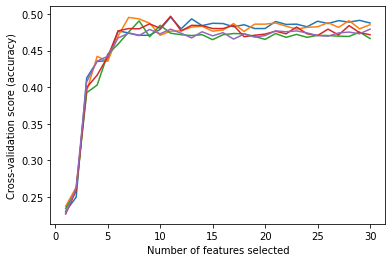

In [46]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (accuracy)")
plt.plot(
    range(1, len(rfecv.grid_scores_)+ 1), rfecv.grid_scores_ )

plt.show()

In [47]:
#... then just do it all with sklearn
# read in
# separate x and y
print('test.shape', test.shape)
# set the target column 
target = train.genre

# remove columns from train
train = train.drop(columns = ['index', 'genre'])
print('train.shape: ',train.shape)
print('target.shape', target.shape)

test.shape (30931, 18)
train.shape:  (50000, 18)
target.shape (50000,)


In [48]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# encode categoric features
# imputers for tempo and duration_ms columns
# scale the data
# select the best features using LinearSVC(penalty = 'l1')
# run an estimator - MLPClassifier(max_iter)
# make pipeline to preprocess
target_encoded = LabelEncoder().fit(target)

pipe = Pipeline([
    ('encoding', OneHotEncoder(handle_unknown = 'ignore')),
    ('tempo_imputer', SimpleImputer(strategy = 'mean')),
    ('duration_imputer', SimpleImputer(missing_values = -1, strategy = 'mean')),
    ('scaler', StandardScaler(with_mean = False,)),
    ('select', SelectFromModel(LinearSVC(penalty = 'l1', dual = False))),
    ('estimator', MLPClassifier(max_iter = 1000))])

x_train, x_test, y_train, y_test = train_test_split(train, 
                                                    target,
                                                   random_state = 309)

In [49]:
pipe

Pipeline(steps=[('encoding', OneHotEncoder(handle_unknown='ignore')),
                ('tempo_imputer', SimpleImputer()),
                ('duration_imputer', SimpleImputer(missing_values=-1)),
                ('scaler', StandardScaler(with_mean=False)),
                ('select',
                 SelectFromModel(estimator=LinearSVC(dual=False,
                                                     penalty='l1'))),
                ('estimator', MLPClassifier(max_iter=1000))])

In [50]:
new_pipe = pipe
new_pipe.fit(x_train, y_train,)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Pipeline(steps=[('encoding', OneHotEncoder(handle_unknown='ignore')),
                ('tempo_imputer', SimpleImputer()),
                ('duration_imputer', SimpleImputer(missing_values=-1)),
                ('scaler', StandardScaler(with_mean=False)),
                ('select',
                 SelectFromModel(estimator=LinearSVC(dual=False,
                                                     penalty='l1'))),
                ('estimator', MLPClassifier(max_iter=1000))])

In [51]:
new_pipe_pred = new_pipe.predict(test)
print(new_pipe_pred)

['Electronic' 'Soul' "Children's Music" ... 'Folk' 'Folk' 'Alternative']


In [52]:
new_pipe_score = new_pipe.score(x_test, y_test)
print(new_pipe_score)

0.63232


In [53]:
# print prediction to file
pred = {'instance_id': test.instance_id,'music_genre': new_pipe_pred}
pred_df = pd.DataFrame(data = pred)
pred_df.to_csv('music_predictions.csv', index = False )